Accuracy: 0.8668


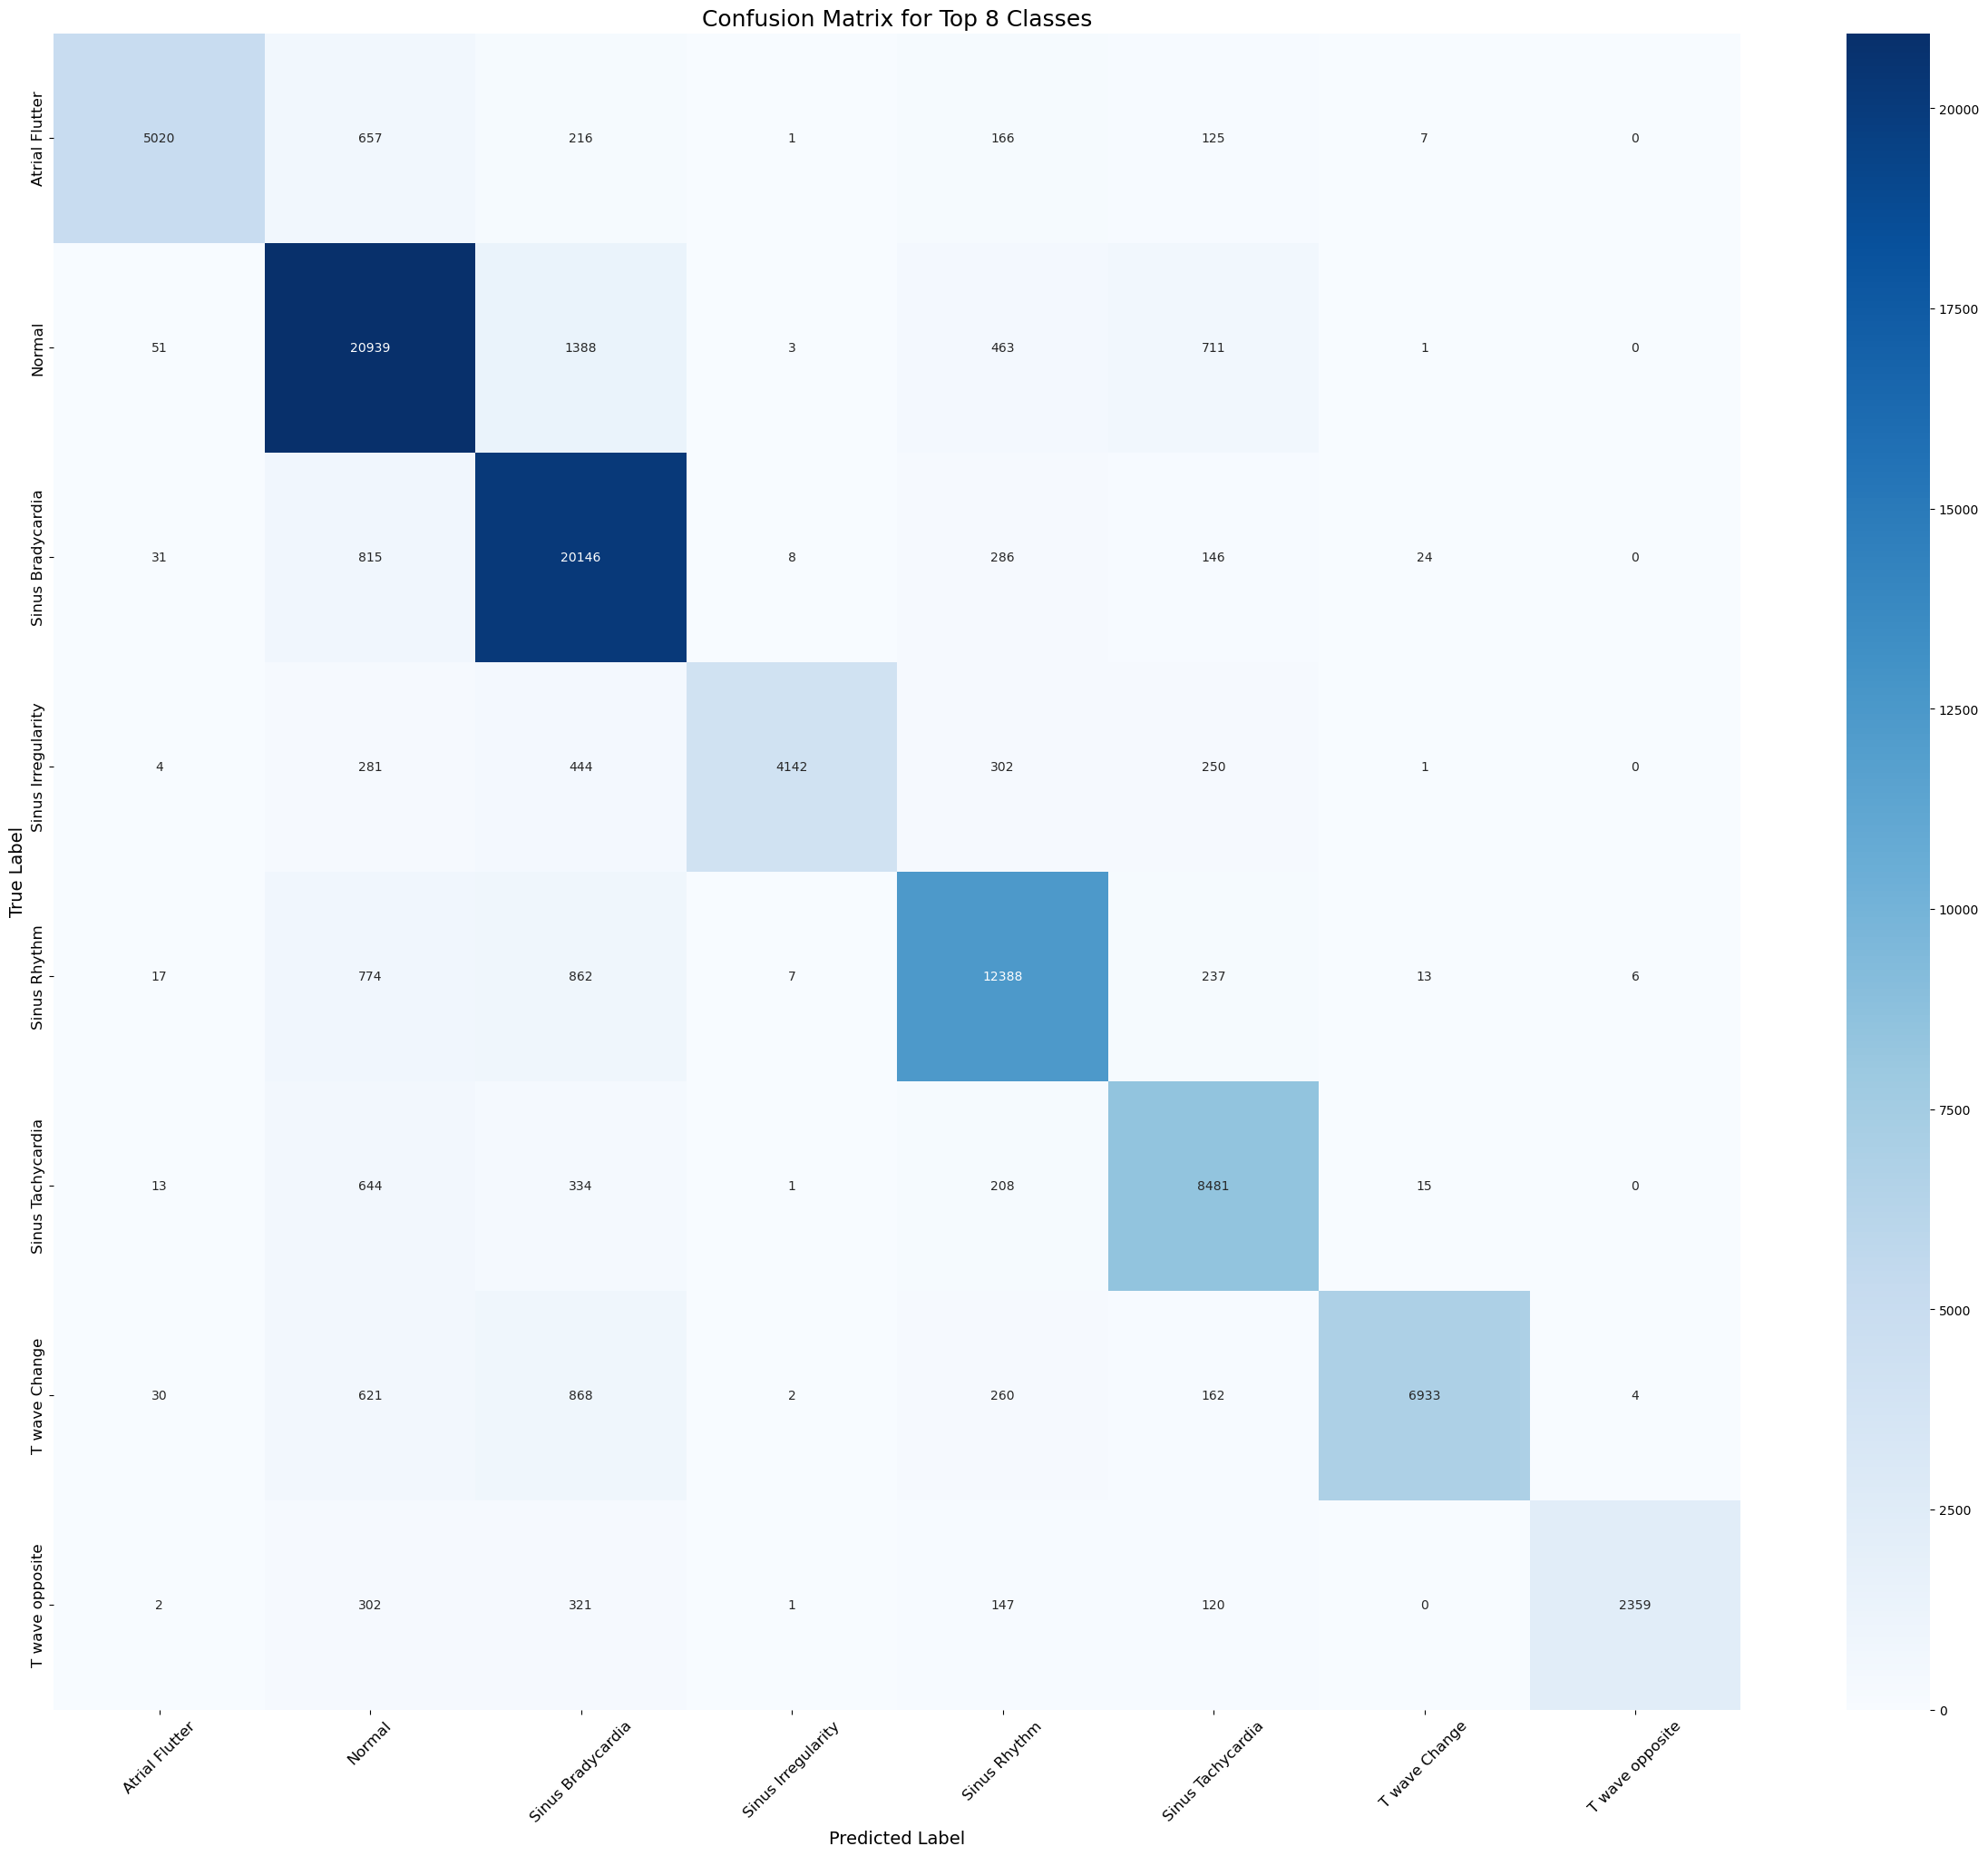

Sensitivity (Recall): 0.8311
Specificity: 0.8311
PPV (Precision): 0.9136


In [2]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize empty lists to store Dask DataFrames from all 12 leads
train_list = []
test_list = []

# Loop over the 12 lead CSV files and read them as Dask DataFrames
for i in range(12):
    train_df = dd.read_csv(f'/Users/matildacotton/Desktop/semester_2_2024/topics/data/training-hctsa-catch22-features-lead-{i}.csv')
    test_df = dd.read_csv(f'/Users/matildacotton/Desktop/semester_2_2024/topics/data/validating-hctsa-catch22-features-lead-{i}.csv')
    
    # Append the Dask DataFrames to the lists
    train_list.append(train_df)
    test_list.append(test_df)

# Concatenate all train and test data
train_combined = dd.concat(train_list, axis=0)
test_combined = dd.concat(test_list, axis=0)

# Compute the Dask DataFrames to bring them into memory as Pandas DataFrames just before training
train_combined = train_combined.compute()
test_combined = test_combined.compute()

# Find the top 8 most frequent classes in the training data
top_8_classes = train_combined['Condition'].value_counts().nlargest(8).index

# Filter the train and test sets to only include the top 8 classes
train_filtered = train_combined[train_combined['Condition'].isin(top_8_classes)]
test_filtered = test_combined[test_combined['Condition'].isin(top_8_classes)]

# Separate features (X) and labels (y) for the filtered training and testing data
X_train = train_filtered.drop('Condition', axis=1).values
y_train = train_filtered['Condition'].values  

X_test = test_filtered.drop('Condition', axis=1).values  
y_test = test_filtered['Condition'].values 

# Initialize the RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict on the test data
y_pred = clf.predict(X_test)

# Calculate and print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Create a DataFrame for the confusion matrix
conf_matrix_df = pd.DataFrame(conf_matrix, 
                            index=np.unique(y_test), 
                            columns=np.unique(y_test))

# Set up the matplotlib figure
plt.figure(figsize=(30, 24))

# Create a heatmap using seaborn
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))

# Add titles and labels
plt.title("Confusion Matrix for Top 8 Classes", fontsize=18)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)

# Customize tick parameters
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.show()


# Calculate sensitivity (recall) and specificity for multiclass classification
# We use `average='macro'` to get the unweighted mean of the metrics for each class
sensitivity = recall_score(y_test, y_pred, average='macro')
specificity = np.mean(np.diag(conf_matrix) / np.sum(conf_matrix, axis=1))  # Custom calculation for specificity
ppv = precision_score(y_test, y_pred, average='macro')

print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"PPV (Precision): {ppv:.4f}")